<a href="https://colab.research.google.com/github/DavidRamosArchilla/GIGA-Piano/blob/main/GIGA_Piano_Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GIGA Piano

This is a project to compose music automatically using artificial intelligence given a priming sequence. It is possible to choose the style of the compositions between baroque, romantic and vanguradist.
***

Credit to the intial model to: https://github.com/asigalov61/tegridy-tools

***

##Step 1. (Setup Environment)

In [ ]:
#@title Install all dependencies (run only once per session)

!git clone https://github.com/DavidRamosArchilla/GIGA-Piano

!pip install gdown --quiet

!pip install tqdm

!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio

In [ ]:
#@title Import all needed modules

print('Loading needed modules. Please wait...')
import os
import random
import copy
import statistics
from collections import OrderedDict

from google.colab import files

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

print('Loading core modules...')
os.chdir('/content/GIGA-Piano')

import TMIDIX
from GPT2RGAX import *

print('Loading aux modules...')

from midi2audio import FluidSynth
import librosa.display
from IPython.display import Audio, display

os.chdir('/content/')

print('Done!')
print('Enjoy!!')

Loading needed modules. Please wait...
Loading core modules...
Loading GPT2-RGA Experimental Module...
GPT2-RGA-X loading complete!
Enjoy!
Loading aux modules...
Done!
Enjoy!!


## Step 2. (MODEL LOAD)

In [ ]:
#@title Load/Reload the model

!mkdir -p /content/modelos/
style = 'Baroque' #@param ['Baroque', 'Romantic', 'Vanguard']
url = ''
if style == 'Baroque':
  url = 'https://drive.google.com/file/d/10SqdZF9SYh5Ox02eTIEqWBmJGgF-UCyr/view?usp=sharing'
elif style == 'Romantic':
  url = 'https://drive.google.com/file/d/1EXy7EW-xERAGr0FxnuSDSwE0r20w0ZlA/view?usp=sharing'
elif style == 'Vanguard':
  url = 'https://drive.google.com/file/d/1B1Ai_rSXtDLyvgABTqCMz5FykVOE_3jJ/view?usp=sharing'

modelname_path = '/content/modelos/' + style + '.pth'
if not os.path.exists(modelname_path):
  !gdown $url --fuzzy -O $modelname_path

model_to_load = modelname_path

print('Loading Small GIGA-Piano model...')
config = GPTConfig(128,
                  1024,
                  dim_feedforward=1024,
                  n_layer=16,
                  n_head=16,
                  n_embd=1024,
                  enable_rpr=True,
                  er_len=1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT(config)

state_dict = torch.load(model_to_load, map_location=device)
state_dict = state_dict['model']

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_state_dict[k] = v

model.load_state_dict(new_state_dict)

model.to(device)

model.eval()

print('Done!')

Downloading...
From: https://drive.google.com/uc?id=10SqdZF9SYh5Ox02eTIEqWBmJGgF-UCyr
To: /content/modelos/Baroque.pth
100% 414M/414M [00:02<00:00, 148MB/s]
Loading Small GIGA-Piano model...
Done!


## Step 3. (GENERATE)

Loading custom MIDI file...
Done!
Converting to MIDI. Please stand-by...
Done! Enjoy! :)
Done!
Displaying resulting composition...


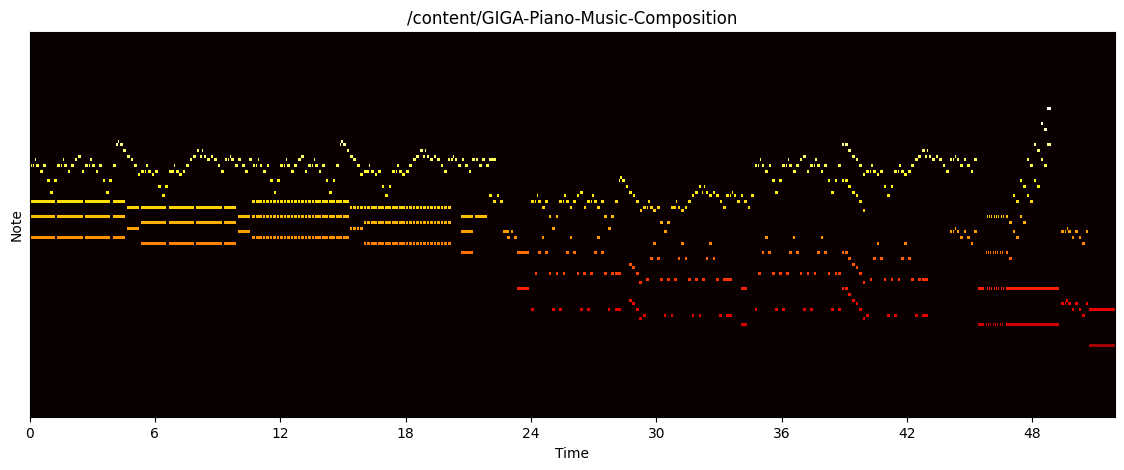

In [ ]:
#@title Choose Priming Sequence
# full_path_to_custom_MIDI = "/content/inicio_para_elisa.mid" #@param {type:"string"}
filenames = {
    'C major arpeggio': '/content/GIGA-Piano/primer_sequences/c_major_arpeggio.mid',
    'C major scale': '/content/GIGA-Piano/primer_sequences/c_major_scale.mid',
    'Clair de Lune': '/content/GIGA-Piano/primer_sequences/clair_de_lune.mid',
    'Ballada G minor Chopin': '/content/GIGA-Piano/primer_sequences/ballada_chopin_lenta.mid',
    'Fur Elise': '/content/GIGA-Piano/primer_sequences/inicio_para_elisa.mid',
    'Nocturne Op9 No2 Chopin': '/content/GIGA-Piano/primer_sequences/inicio_nocturno.mid',
    'Married Live Melody': '/content/GIGA-Piano/primer_sequences/Married_Life_melodia.mid',
    'Moonlight Sonata': '/content/GIGA-Piano/primer_sequences/moonlight_sonata.mid',
    'Prelude C Major Bach': '/content/GIGA-Piano/primer_sequences/prelude_in_c_major.mid',
    'Trip to Ireland': '/content/GIGA-Piano/primer_sequences/Trip to Ireland.mid',
}

primer = 'Trip to Ireland'  #@param ['Prelude C Major Bach', 'Moonlight Sonata', 'Nocturne Op9 No2 Chopin', 'Trip to Ireland', 'Fur Elise', 'Ballada G minor Chopin', 'C major arpeggio', 'C major scale', 'Clair de Lune', 'Upload your own!']

if primer == 'Upload your own!':
  data = list(files.upload().keys())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  full_path_to_custom_MIDI = '/content/' + data[0]
else:
  full_path_to_custom_MIDI = filenames[primer]

simulated_or_constant_velocity = False #@param {type:"boolean"}

print('Loading custom MIDI file...')

#print('Loading MIDI file...')
score = TMIDIX.midi2ms_score(open(full_path_to_custom_MIDI, 'rb').read())

events_matrix = []

itrack = 1

while itrack < len(score):
    for event in score[itrack]:
        if event[0] == 'note' and event[3] != 9:
            events_matrix.append(event)
    itrack += 1

# Sorting...
events_matrix.sort(key=lambda x: x[4], reverse=True)
events_matrix.sort(key=lambda x: x[1])

# recalculating timings
for e in events_matrix:
    e[1] = int(e[1] / 16)
    e[2] = int(e[2] / 32)

# final processing...

melody = []
melody_chords = []

pe = events_matrix[0]
for e in events_matrix:

    time = max(0, min(126, e[1]-pe[1]))
    dur = max(1, min(126, e[2]))

    ptc = max(1, min(126, e[4]))

    melody_chords.append([time, dur, ptc])

    if time != 0:
      if ptc < 60:
        ptc = (ptc % 12) + 60
      melody.append([time, dur, ptc])

    pe = e

inputs = []

for m in melody_chords:
  inputs.extend([127])
  inputs.extend(m)

inputs.extend([127])

print('Done!')

out1 = inputs

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

# Single Block

In [ ]:
#@title Single Continuation Block Generator

#@markdown NOTE: Play with the settings to get different results

#@markdown Weather to use or not the prime squence
use_prime_sequence = True #@param {type:"boolean"}
#@markdown Length of the prime sequence
number_of_prime_tokens = 256 #@param {type:"slider", min:32, max:512, step:8}
#@markdown "Creativity" of the AI
temperature = 0.85 #@param {type:"slider", min:0.1, max:3, step:0.05}
#@markdown Number of pieces to generate
number_of_batches = 3 #@param {type:"slider", min:1, max:8, step:1}
show_stats = True #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Continuation Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Number of prime tokens:', number_of_prime_tokens)
print('Model temperature:', temperature)
print('Number of batches:', number_of_batches)
print('=' * 70)
print('Generating...')

if use_prime_sequence:
  inp = inputs[:number_of_prime_tokens+1]
else:
  inp = [127]

rand_seq = model.generate_batches(torch.Tensor(inp),
                                          target_seq_length=1024,
                                          temperature=temperature,
                                          num_batches=number_of_batches,
                                          verbose=show_stats)

out1 = rand_seq[0].cpu().numpy().tolist()

print('Done!')

In [ ]:
#@title Explore generated continuations
#@markdown Move the slider to choose witch composition you want to display

batch_number = 2 #@param {type:"slider", min:0, max:7, step:1}
simulated_or_constant_velocity = True #@param {type:"boolean"}

if batch_number >= number_of_batches:
  bn = 0
else:
  bn = batch_number

print('=' * 70)
print('Displaying batch #:',bn )
print('=' * 70)

out1 = rand_seq[bn].cpu().numpy().tolist()

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

# The rest of the notebook is experimental, feel free to try it for yourself.

# Multiple Blocks

In [ ]:
#@title Multiple Continuation Blocks Generator

#@markdown NOTE: Play with the settings to get different results

custom_MIDI_or_improvisation = True #@param {type:"boolean"}
number_of_prime_tokens = 128 #@param {type:"slider", min:32, max:512, step:8}
number_of_continuation_blocks = 200 #@param {type:"slider", min:1, max:2000, step:1}
temperature = 0.9 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Continuation Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Number of prime tokens:', number_of_prime_tokens)
print('Number of continuation blocks:', number_of_continuation_blocks)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

out1 = []

if custom_MIDI_or_improvisation:
  out1 = inputs[:number_of_prime_tokens]
  out1.extend([127])
else:
  out1.extend([127])

for i in tqdm(range(number_of_continuation_blocks)):

  rand_seq = model.generate(torch.Tensor(out1[-1021:]),
                                            target_seq_length=len(out1[-1021:])+3,
                                            temperature=temperature,
                                            stop_token=127,
                                            verbose=show_stats)

  out = rand_seq[0].cpu().numpy().tolist()

  out1.extend(out[-3:])
  out1.extend([127])

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

In [ ]:
#@title KNN Multiple Continuation Blocks Generator

#@markdown NOTE: Play with the settings to get different results

custom_MIDI_or_improvisation = True #@param {type:"boolean"}
number_of_prime_tokens = 256 #@param {type:"slider", min:32, max:512, step:8}
number_of_continuation_blocks = 200 #@param {type:"slider", min:10, max:2000, step:10}
number_of_memory_tokens = 256 #@param {type:"slider", min:16, max:1008, step:16}
number_of_batches = 4 #@param {type:"slider", min:1, max:8, step:1}
knn_overfitting_threshold = 0.1 #@param {type:"slider", min:0, max:2, step:0.1}
refit_knn_classifier_each_iteration = False #@param {type:"boolean"}
temperature = 0.9 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Continuation Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Number of prime tokens:', number_of_prime_tokens)
print('Number of continuation blocks:', number_of_continuation_blocks)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(melody_chords)
knn_melody_chords = copy.deepcopy(melody_chords[:(number_of_prime_tokens // 4)])

out1 = []

if custom_MIDI_or_improvisation:
  out1 = inputs[:number_of_prime_tokens]
  out1.extend([127])
else:
  out1.extend([127])

for i in tqdm(range(number_of_continuation_blocks)):

  rand_seq = model.generate_batches(torch.Tensor(out1[-number_of_memory_tokens-1:]),
                                            target_seq_length=len(out1[-number_of_memory_tokens-1:])+3,
                                            temperature=temperature,
                                            num_batches=number_of_batches,
                                            verbose=show_stats)

  out = rand_seq.cpu().tolist()

  notes = []

  for i in range(len(out)):
    notes.append(out[i][-3:])

  if refit_knn_classifier_each_iteration:
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(knn_melody_chords)

  out = notes[np.where(neigh.kneighbors(notes) >= np.array([knn_overfitting_threshold]))[1][0]]

  knn_melody_chords.append(out)

  out1.extend(out)
  out1.extend([127])

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

In [ ]:
from torch import pairwise_distance
#@title Euclidian Distance Multiple Continuation Blocks Generator

#@markdown NOTE: Play with the settings to get different results

custom_MIDI_or_improvisation = True #@param {type:"boolean"}
number_of_prime_tokens = 256 #@param {type:"slider", min:32, max:512, step:8}
number_of_continuation_blocks = 100 #@param {type:"slider", min:10, max:2000, step:10}
number_of_memory_tokens = 256 #@param {type:"slider", min:16, max:1008, step:16}
number_of_batches = 4 #@param {type:"slider", min:1, max:8, step:1}
euclidian_distance_type = "Min" #@param ["Min", "Median", "Mean"]
euclidian_distance_match_type = "Times-Durations-Pitches" #@param ["Times-Durations-Pitches", "Durations-Pitches", "Pitches"]
temperature = 0.9 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Continuation Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Number of prime tokens:', number_of_prime_tokens)
print('Number of continuation blocks:', number_of_continuation_blocks)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

out1 = []

if custom_MIDI_or_improvisation:
  out1 = inputs[:number_of_prime_tokens]
  out1.extend([127])
else:
  out1.extend([127])

for i in tqdm(range(number_of_continuation_blocks)):

  rand_seq = model.generate_batches(torch.Tensor(out1[-number_of_memory_tokens-1:]),
                                            target_seq_length=len(out1[-number_of_memory_tokens-1:])+3,
                                            temperature=temperature,
                                            num_batches=number_of_batches,
                                            verbose=show_stats)

  out = rand_seq.cpu().tolist()

  notes = []

  for i in range(len(out)):
    notes.append(out[i][-3:])

  min_euc_dist = []
  avg_euc_dist = [] # Mean
  med_euc_dist = []

  for j in range(len(notes)):
    euc_dist = []
    for i in range(len(melody_chords)):

      if euclidian_distance_match_type == 'Times-Durations-Pitches':
        euc_dist.append(pairwise_distances([notes[j]], [melody_chords[i]])[0][0])
      if euclidian_distance_match_type == 'Durations-Pitches':
        euc_dist.append(pairwise_distances([notes[j][1:]], [melody_chords[i][1:]])[0][0])
      if euclidian_distance_match_type == 'Pitches':
        euc_dist.append(pairwise_distances([[notes[j][2]]], [[melody_chords[i][2]]])[0][0])

    min_euc_dist.append(min(euc_dist))
    avg_euc_dist.append(sum(euc_dist) / len(euc_dist))
    med_euc_dist.append(statistics.median(euc_dist))

  if euclidian_distance_type == 'Min':
    out = notes[min_euc_dist.index(min(min_euc_dist))]

  if euclidian_distance_type == 'Mean':
    out = notes[avg_euc_dist.index(min(avg_euc_dist))]

  if euclidian_distance_type == 'Median':
    out = notes[med_euc_dist.index(min(med_euc_dist))]

  out1.extend(out)
  out1.extend([127])

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

# Inpainting / Controlled Generation

In [ ]:
#@title Custom MIDI Inpaiting / Controlled Generator

#@markdown NOTE: Play with the settings to get different results

control_type = "Time" #@param ["Time", "Time-Duration"]
number_of_prime_notes = 8 #@param {type:"slider", min:1, max:128, step:1}
temperature = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Inpainting / Controlled Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Control type:', control_type)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

out1 = []

for m in melody_chords[:number_of_prime_notes]:
  out1.extend([127])
  out1.extend(m)
out1.extend([127])

if control_type == 'Time':
  ctrl = 1022
  out1.extend(melody_chords[number_of_prime_notes+1][:1])
else:
  ctrl = 1023
  out1.extend(melody_chords[number_of_prime_notes+1][:2])


for i in tqdm(range(number_of_prime_notes+2, len(melody_chords))):

  rand_seq = model.generate(torch.Tensor(out1[-ctrl:]),
                                            target_seq_length=1024,
                                            temperature=temperature,
                                            stop_token=127,
                                            verbose=False)

  out = rand_seq[0].cpu().numpy().tolist()

  if control_type == 'Time':

    out1.extend(out[-2:])
    out1.extend([127])
    out1.extend(melody_chords[i][:1])
  else:
    out1.extend([out[-1]])
    out1.extend([127])
    out1.extend(melody_chords[i][:2])

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

In [ ]:
#@title Alternative Custom MIDI Inpaiting / Controlled Generator

#@markdown NOTE: Play with the settings to get different results

control_type = "Time" #@param ["Time", "Time-Duration"]
number_of_prime_notes = 12 #@param {type:"slider", min:2, max:128, step:2}
temperature = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Inpainting / Controlled Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Control type:', control_type)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

out1 = []

for m in melody_chords[:number_of_prime_notes]:
  out1.extend([127])
  out1.extend(m)
out1.extend([127])

if control_type == 'Time':
  ctrl = 1022
  out1.extend(melody_chords[number_of_prime_notes+1][:1])
else:
  ctrl = 1023
  out1.extend(melody_chords[number_of_prime_notes+1][:2])


for i in tqdm(range(number_of_prime_notes+2, len(melody_chords)-2, 2)):

  rand_seq = model.generate(torch.Tensor(out1[-ctrl:]),
                                            target_seq_length=1024,
                                            temperature=temperature,
                                            stop_token=127,
                                            verbose=False)

  out = rand_seq[0].cpu().numpy().tolist()

  if control_type == 'Time':

    out1.extend(out[-2:])
    out1.extend([127])
  else:
    out1.extend([out[-1]])
    out1.extend([127])

  out1.extend(melody_chords[i+1])
  out1.extend([127])

  if control_type == 'Time':
    out1.extend(melody_chords[i+2][:1])
  else:
    out1.extend(melody_chords[i+2][:2])


if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

# Melody Harmonization

In [ ]:
#@title Melody Harmonization Generator

#@markdown NOTE: Play with the settings to get different results

number_of_prime_notes = 14 #@param {type:"slider", min:1, max:64, step:1}
number_of_notes_per_chord = 2 #@param {type:"slider", min:1, max:5, step:1}
random_number_of_notes_per_chord = False #@param {type:"boolean"}
temperature = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = True #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}


#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Melody Harmonization Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Number of prime notes:', number_of_prime_notes)
print('Model temperature:', temperature)
print('=' * 70)
print('Generating...')

inp = []

for i in range(number_of_prime_notes):
  inp.extend([127])
  inp.extend(melody[i])

for i in tqdm(range(number_of_prime_notes+1, len(melody))):

  inp.extend([127])
  inp.extend(melody[i])


  if random_number_of_notes_per_chord:
    nnpc = random.randint(1, number_of_notes_per_chord)
  else:
    nnpc = number_of_notes_per_chord

  for j in range(nnpc):
    inp.extend([127])
    inp.extend([0])

    rand_seq = model.generate(torch.Tensor(inp[-1022:]),
                                              target_seq_length=1024,
                                              temperature=temperature,
                                              stop_token=127,
                                              verbose=show_stats)

    out = rand_seq[0].cpu().numpy().tolist()

    inp.extend(out[-2:])


out1 = inp

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

# Notes / Chords Progressions

In [ ]:
#@title Notes Progressions Generator

#@markdown NOTE: Play with the settings to get different results
control_type = "Time" #@param ["Time", "Time-Duration"]
number_of_notes_to_generate = 300 #@param {type:"slider", min:10, max:5000, step:1}
desired_time = 8 #@param {type:"slider", min:1, max:127, step:1}
desired_duration = 7 #@param {type:"slider", min:1, max:127, step:1}
temperature = 1.3 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Notes Progressions Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Control Type:', control_type)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

out1 = [127]

if control_type == 'Time':
  ctrl = 1022
  out1.extend([desired_time])

else:
  ctrl = 1023
  out1.extend([desired_time])
  out1.extend([desired_duration])

for i in tqdm(range(number_of_notes_to_generate)):

  rand_seq = model.generate(torch.Tensor(out1[-ctrl:]),
                                            target_seq_length=1024,
                                            temperature=temperature,
                                            stop_token=127,
                                            verbose=show_stats)

  out = rand_seq[0].cpu().numpy().tolist()

  if control_type == 'Time':

    out1.extend(out[-2:])
    out1.extend([127])
    out1.extend([desired_time])

  else:
    out1.extend(out[-1:])
    out1.extend([127])
    out1.extend([desired_time])
    out1.extend([desired_duration])

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))

In [ ]:
#@title Chords Progressions Generator

#@markdown NOTE: Play with the settings to get different results
control_type = "Time" #@param ["Time", "Time-Duration"]
number_of_chords_to_generate = 40 #@param {type:"slider", min:10, max:200, step:1}
number_of_notes_per_chord = 3 #@param {type:"slider", min:1, max:5, step:1}
random_number_of_notes_per_chord = False #@param {type:"boolean"}
desired_time = 20 #@param {type:"slider", min:1, max:127, step:1}
desired_duration = 20 #@param {type:"slider", min:1, max:127, step:1}
temperature = 0.9 #@param {type:"slider", min:0.1, max:2, step:0.1}
simulated_or_constant_velocity = False #@param {type:"boolean"}
show_stats = False #@param {type:"boolean"}

#===================================================================
print('=' * 70)
print('GIGA Piano Music Model Chords Progressions Generator')
print('=' * 70)

print('Generation settings:')
print('=' * 70)
print('Control Type:', control_type)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

out1 = [127]

if control_type == 'Time':
  ctrl = 1022
  out1.extend([desired_time])

else:
  ctrl = 1023
  out1.extend([desired_time])
  out1.extend([desired_duration])

nnpc = number_of_notes_per_chord

for i in tqdm(range(number_of_chords_to_generate)):

  rand_seq = model.generate(torch.Tensor(out1[-ctrl:]),
                                            target_seq_length=1024,
                                            temperature=temperature,
                                            stop_token=127,
                                            verbose=show_stats)

  out = rand_seq[0].cpu().numpy().tolist()

  if control_type == 'Time':
    out1.extend(out[-2:])
    out1.extend([127])
  else:
    out1.extend(out[-1:])
    out1.extend([127])

  if random_number_of_notes_per_chord:
    nnpc = random.randint(1, number_of_notes_per_chord)

  for j in range(nnpc):
    out1.extend([0])

    if control_type == 'Time-Duration':
      out1.extend([desired_duration])

    rand_seq = model.generate(torch.Tensor(out1[-ctrl:]),
                                          target_seq_length=1024,
                                          temperature=temperature,
                                          stop_token=127,
                                          verbose=show_stats)

    out = rand_seq[0].cpu().numpy().tolist()

    if control_type == 'Time':
        out1.extend(out[-2:])
        out1.extend([127])
    else:
      out1.extend(out[-1:])
      out1.extend([127])

  if control_type == 'Time':
    out1.extend([desired_time])

  else:
    out1.extend([desired_time])
    out1.extend([desired_duration])

if len(out1) != 0:

    song = out1
    song_f = []
    time = 0
    dur = 0
    vel = 0
    pitch = 0
    channel = 0

    son = []

    song1 = []

    for s in song:
      if s != 127:
        son.append(s)

      else:
        if len(son) == 3:
          song1.append(son)
        son = []

    song2 = []
    cho = []
    for s in song1:
      if s[0] == 0:
        cho.append(s)
      else:
        song2.append(cho)
        cho = []
        cho.append(s)

    for s in song2:
      if len(s) > 0:

        channel = 0

        if simulated_or_constant_velocity:
          if len(s) == 1:
            vel = s[0][2] + 10
          else:
            vel = s[0][2] + 30
        else:
          vel = 90

        for ss in s:

          time += ss[0] * 16

          dur = ss[1] * 32

          pitch = ss[2]

          song_f.append(['note', time, dur, channel, pitch, vel ])

    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'GIGA Piano',
                                                        output_file_name = '/content/GIGA-Piano-Music-Composition',
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 0, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)

    print('Done!')

print('Displaying resulting composition...')
fname = '/content/GIGA-Piano-Music-Composition'

pr_duration = song_f[-1][1]+song_f[-1][2]

pianoroll = [[0] * pr_duration for i in range(128)]

for s in song_f:
  for i in range(s[2]):
    try:
      pianoroll[s[4]][i+s[1]] = s[4]
    except:
      pass

piano_roll = np.array(pianoroll)

plt.figure(figsize=(14, 5))
librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=1, hop_length=16, sr=16000, cmap=plt.cm.hot)
plt.title(fname)

FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
display(Audio(str(fname + '.wav'), rate=16000))


# Congrats! You did it! :)